In [183]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV

# Paper = https://drive.google.com/file/d/1lUtlu1vdGMymo8lkOTl_cftfcPDJMk0X/view?usp=sharing

In [139]:
df = pd.read_csv('datasets/preprocessed_df.csv')
df[['arrival_date','reservation_status_date']] = df[['arrival_date','reservation_status_date']].apply(pd.to_datetime)
df

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,...,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,kids,total_guests,is_family,total_stays
0,Resort Hotel,0,342,7,27,0,0,2,BB,PRT,...,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0
1,Resort Hotel,0,400,7,27,0,0,2,BB,PRT,...,0.00,0,0,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0
2,Resort Hotel,0,7,7,27,0,1,1,BB,GBR,...,75.00,0,0,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1
3,Resort Hotel,0,13,7,27,0,1,1,BB,GBR,...,75.00,0,0,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1
4,Resort Hotel,0,14,7,27,0,2,2,BB,GBR,...,98.00,0,1,Check-Out,2015-07-03,2015-07-01,0.0,2.0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86998,City Hotel,0,23,8,35,2,5,2,BB,BEL,...,96.14,0,0,Check-Out,2017-09-06,2017-08-01,0.0,2.0,0,7
86999,City Hotel,0,102,8,35,2,5,3,BB,FRA,...,225.43,0,2,Check-Out,2017-09-07,2017-08-01,0.0,3.0,0,7
87000,City Hotel,0,34,8,35,2,5,2,BB,DEU,...,157.71,0,4,Check-Out,2017-09-07,2017-08-01,0.0,2.0,0,7
87001,City Hotel,0,109,8,35,2,5,2,BB,GBR,...,104.40,0,0,Check-Out,2017-09-07,2017-08-01,0.0,2.0,0,7


In [140]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date', 'kids',
       'total_guests', 'is_family', 'total_stays'],
      dtype='object')

In [141]:
df.reservation_status.unique()

array(['Check-Out', 'Canceled', 'No-Show'], dtype=object)

## Reservas do tipo 'No-show' serão classificadas como 'Canceled'

In [142]:
df.loc[df.reservation_status == 'No-Show', 'reservation_status'] = 'Canceled'
df.reservation_status.unique()

array(['Check-Out', 'Canceled'], dtype=object)

## Feature engineering: colunas Lead Time, Days in Waiting List e Previous Cancellation
comentario [2]

In [143]:
df[['lead_time', 'reservation_status_date', 'arrival_date']]

,lead_time,reservation_status_date,arrival_date
0,342,2015-07-01,2015-07-01
1,400,2015-07-01,2015-07-01
2,7,2015-07-02,2015-07-01
3,13,2015-07-02,2015-07-01
4,14,2015-07-03,2015-07-01
...,...,...,...
86998,23,2017-09-06,2017-08-01
86999,102,2017-09-07,2017-08-01
87000,34,2017-09-07,2017-08-01
87001,109,2017-09-07,2017-08-01


In [144]:
df.loc[df.reservation_status == 'Canceled', 'lead_time'] = df.lead_time - (df.arrival_date - df.reservation_status_date) / np.timedelta64(1, 'D')

### Previous cancellations

In [145]:
df['previous_cancellation_ratio'] = df.previous_cancellations / (df.previous_cancellations + df.previous_bookings_not_canceled)
df.previous_cancellation_ratio.fillna(0, inplace=True)
df.previous_cancellation_ratio.unique()

array([0. , 0.5, 1. ])

### Days in waiting list

In [146]:
df['was_in_waiting_list'] = np.where(df.days_in_waiting_list > 0, 1, 0)

## Encodificação de features categóricas: Customer Type, Deposit Type e Distribution Channel

In [147]:
df['sales_information'] = df.customer_type + ' ' + df.deposit_type + ' ' + df.distribution_channel
df

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,meal,country,...,reservation_status,reservation_status_date,arrival_date,kids,total_guests,is_family,total_stays,previous_cancellation_ratio,was_in_waiting_list,sales_information
0,Resort Hotel,0,342,7,27,0,0,2,BB,PRT,...,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0,0.0,0,Transient No Deposit Direct
1,Resort Hotel,0,400,7,27,0,0,2,BB,PRT,...,Check-Out,2015-07-01,2015-07-01,0.0,2.0,0,0,0.0,0,Transient No Deposit Direct
2,Resort Hotel,0,7,7,27,0,1,1,BB,GBR,...,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1,0.0,0,Transient No Deposit Direct
3,Resort Hotel,0,13,7,27,0,1,1,BB,GBR,...,Check-Out,2015-07-02,2015-07-01,0.0,1.0,0,1,0.0,0,Transient No Deposit Corporate
4,Resort Hotel,0,14,7,27,0,2,2,BB,GBR,...,Check-Out,2015-07-03,2015-07-01,0.0,2.0,0,2,0.0,0,Transient No Deposit TA/TO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86998,City Hotel,0,23,8,35,2,5,2,BB,BEL,...,Check-Out,2017-09-06,2017-08-01,0.0,2.0,0,7,0.0,0,Transient No Deposit TA/TO
86999,City Hotel,0,102,8,35,2,5,3,BB,FRA,...,Check-Out,2017-09-07,2017-08-01,0.0,3.0,0,7,0.0,0,Transient No Deposit TA/TO
87000,City Hotel,0,34,8,35,2,5,2,BB,DEU,...,Check-Out,2017-09-07,2017-08-01,0.0,2.0,0,7,0.0,0,Transient No Deposit TA/TO
87001,City Hotel,0,109,8,35,2,5,2,BB,GBR,...,Check-Out,2017-09-07,2017-08-01,0.0,2.0,0,7,0.0,0,Transient No Deposit TA/TO


In [148]:
le = LabelEncoder()
le.fit(df.sales_information)
df.sales_information = le.fit_transform(df.sales_information)

## Remover coluna Country
- comentario [1]


In [150]:
df.drop(['country'], axis=1, inplace=True)

## Convenience splitting
- comentario [0]

In [167]:
df.arrival_date = df.arrival_date.apply(lambda x: x.strftime('%Y-%m'))
gb = df.groupby('arrival_date')
df_by_months = [gb.get_group(x) for x in gb.groups]
df_by_months[0].arrival_date

0        2015-07
1        2015-07
2        2015-07
3        2015-07
4        2015-07
          ...   
52926    2015-07
52930    2015-07
52931    2015-07
52932    2015-07
52933    2015-07
Name: arrival_date, Length: 1671, dtype: object

In [176]:
X_train, X_test = train_test_split(df_by_months[0], train_size=.75, shuffle=True)
for month in df_by_months[1:]:
    train, test = train_test_split(month, train_size=.75, shuffle=True)
    X_train = pd.concat([X_train, train], ignore_index=True)
    X_test = pd.concat([X_test, test], ignore_index=True)


In [177]:
cols = [
    'lead_time', 'is_repeated_guest', 'booking_changes', 'adr', 'total_guests', 'is_family', 'total_stays',
    'previous_cancellation_ratio', 'was_in_waiting_list', 'sales_information'
]
X_train, y_train = X_train[cols], X_train['is_canceled']
X_test, y_test = X_test[cols], X_test['is_canceled']

# Random Forest

In [180]:
rf = RandomForestClassifier()
params_rf = {
    'n_estimators': [10, 50, 100, 150],
    'max_depth': [None, 3, 5],
    'criterion': ['gini', 'entropy', 'log_loss']

}
rf_gs = GridSearchCV(rf, param_grid=params_rf, cv=5)
rf_gs.fit(X_train, y_train)
print(f'rf_gs.best.score_ (Melhor score do random forest): {rf_gs.best_score_}')
print(f'rf_gs.best.params_ (Melhores hiperparâmetros do random forest): {rf_gs.best_params_}')
rf_gs.best_estimator_

rf_gs.best.score_ (Melhor score do random forest): 0.7303575839385565
rf_gs.best.params_ (Melhores hiperparâmetros do random forest): {'criterion': 'log_loss', 'max_depth': 5, 'n_estimators': 10}


RandomForestClassifier(criterion='log_loss', max_depth=5, n_estimators=10)

In [181]:
rf_gs.score(X_train,y_train), rf_gs.score(X_test, y_test)

(0.7388492075656785, 0.7357198658149902)

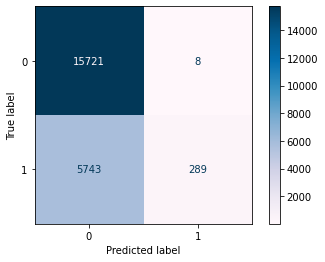

In [184]:
matrix = ConfusionMatrixDisplay.from_predictions(y_test, rf_gs.predict(X_test), cmap='PuBu')